# Arabidopsis transcriptome study under high light stress

In [1]:
# Import modules from pyseqrna package

from pyseqrna import pyseqrna_utils as pu
from pyseqrna import quality_check as qc
from pyseqrna import quality_trimming as qt
from pyseqrna import  aligners as al
from pyseqrna import pyseqrna_stats as ps
from pyseqrna import quantification as quants
from pyseqrna import differential_expression as de
from pyseqrna import pyseqrna_plots as pp
from pyseqrna import multimapped_groups as mmg
import pandas as pd
import dill
from waiting import wait

In [2]:
# initialize the logger
from pyseqrna.pyseqrna_utils import PyseqrnaLogger

log = PyseqrnaLogger(mode='w', log='pp')

log.info("Analysis started")

[11:41:20]  <ipython-input-2-09f797b7f757> :: INFO : Analysis started


In [15]:
# Read input samples form input file
data = pu.read_input_file("/home/naveen/Downloads/arabidopsis/input_sample.txt", "/home/naveen/Downloads/arabidopsis/" )
samples= data['samples']

[10:54:23]  pyseqrna_utils :: INFO : Reading input samples File 
[10:54:23]  pyseqrna_utils :: INFO : Input file /home/naveen/Downloads/arabidopsis/input_sample.txt read succesfully
[10:54:23]  pyseqrna_utils :: INFO : Combination created succesfully from /home/naveen/Downloads/arabidopsis/input_sample.txt
[10:54:23]  pyseqrna_utils :: INFO : targets dataframe for differenatial created succesfully from /home/naveen/Downloads/arabidopsis/input_sample.txt


In [18]:
samples

{'GL0.5h1': ['GL0.5h1',
  'GL0.5',
  '/home/naveen/Downloads/arabidopsis/SRR6767632.fastq.gz'],
 'GL0.5h2': ['GL0.5h2',
  'GL0.5',
  '/home/naveen/Downloads/arabidopsis/SRR6767633.fastq.gz'],
 'GL6h1': ['GL6h1',
  'GL6',
  '/home/naveen/Downloads/arabidopsis/SRR6767634.fastq.gz'],
 'GL6h2': ['GL6h2',
  'GL6',
  '/home/naveen/Downloads/arabidopsis/SRR6767635.fastq.gz'],
 'GL12h1': ['GL12h1',
  'GL12',
  '/home/naveen/Downloads/arabidopsis/SRR6767636.fastq.gz'],
 'GL12h2': ['GL12h2',
  'GL12',
  '/home/naveen/Downloads/arabidopsis/SRR6767637.fastq.gz'],
 'GL24h1': ['GL24h1',
  'GL24',
  '/home/naveen/Downloads/arabidopsis/SRR6767639.fastq.gz'],
 'GL24h2': ['GL24h2',
  'GL24',
  '/home/naveen/Downloads/arabidopsis/SRR6767640.fastq.gz'],
 'GL48h1': ['GL48h1',
  'GL48',
  '/home/naveen/Downloads/arabidopsis/SRR6767642.fastq.gz'],
 'GL48h2': ['GL48h2',
  'GL48',
  '/home/naveen/Downloads/arabidopsis/SRR6767643.fastq.gz'],
 'GL72h1': ['GL72h1',
  'GL72',
  '/home/naveen/Downloads/arabidopsis/

In [ ]:
outdir="pySeqRNA_results"

In [ ]:
import glob 

outa = glob.glob("pySeqRNA_results/star_results.1/*out.bam")



In [19]:
outalign={}
for s in samples:
    for o in outa:
        if s in o:
            outalign[s]=[samples[s][0], samples[s][1],o]
        

In [21]:
mmmgs = mmg.countMMG(sampleDict=samples, bamDict=outalign, gff="/home/naveen/Downloads/arabidopsis/Arabidopsis_thaliana.TAIR10.51.gff3")

/home/naveen/SOFTWARE/miniconda3/envs/pySeqRNA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements

In [ ]:
# initial quality check
outfastqc, jobfastqc = qc.fastqcRun(sampleDict=samples, slurm=True,cpu=30,mem=200, outDir=outdir)

for job in jobfastqc:
    wait(lambda: pu.check_status(job), waiting_for="quality to finish")
    log.info(f"Quality check completed for job {job}")

log.info("Read quality check completed succesfully")



In [ ]:
# Run trimming using trimming module
outtrim, jobtrim= qt.trim_galoreRun(sampleDict=samples,  slurm=True, cpu=40,mem=200)

for job in jobtrim:
    wait(lambda: pu.check_status(job), waiting_for="trimming to finish")
    log.info(f"Trimming completed for job {job}")

log.info("Read trimming completed succesfully")

In [ ]:
aligner = al.STAR_Aligner(genome="/home/naveen/Downloads/arabidopsis/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa", slurm=True, outDir=outdir)

In [ ]:
job = aligner.build_index()
wait(lambda: pu.check_status(job), waiting_for="alignment to finish")
log.info(f"Indexing completed for job {job}")
log.info("Genome indexing completed succesfully")

In [ ]:
aligner.check_index()

In [ ]:
outalign, jobalign = aligner.run_Alignment(target=outtrim, cpu=20, mem=200)

for job in jobalign:
    wait(lambda: pu.check_status(job), waiting_for="alignment to finish")
    log.info(f"Alignment completed for job {job}")
log.info("Read alignment completed succesfully")

In [ ]:
df= ps.align_stats(sampleDict=samples,trimDict=outtrim,bamDict=outalign)

In [ ]:
df.to_excel(outdir+"/alignment_stats.xlsx", index=False)

In [ ]:
a= quants.featureCount(bamDict=outalign, gff="/home/naveen/Downloads/arabidopsis/Arabidopsis_thaliana.TAIR10.51.gff3", outDir=outdir)

In [16]:
counts= pd.read_csv(outdir+"/Counts_final.txt", sep="\t")

In [17]:
targets= data['targets']
comb= data['combinations']

In [18]:
comb = ['GL0.5-HL0.5','GL6-HL6','GL6-HL12','GL48-HL48','GL72-HL72','R14-HL72', 'R14-GL72']

In [19]:
dd= de.runDESeq2(countDF=counts,targetFile=targets,design='sample', subset=False, combination=comb)

In [ ]:
dd= de.run_edgeR(countDF=counts,targetFile=targets, subset=False, combination=comb)

In [ ]:
import os 
dd.to_excel(os.path.join(outdir,"Raw_DEGs_all_edgeR.xlsx"), index=False)

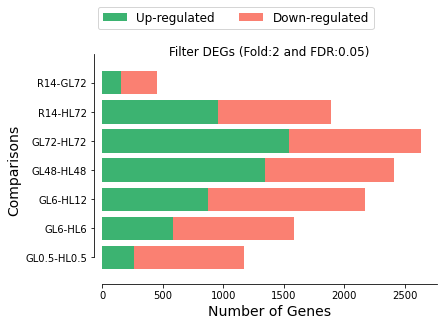

In [20]:
# dd= pd.read_excel(outdir+"/Raw_DEGs_all_edgeR.xlsx")
filtered_DEG = de.degFilter(degDF=dd, CompareList=comb, FDR=0.05, FOLD=2)

In [21]:
summary= filtered_DEG['summary']
summary

,Comparisons,Total_DEGs,Up_DEGs,Down_DEGs
0,GL0.5-HL0.5,1173,267,906
1,GL6-HL6,1584,583,1001
2,GL6-HL12,2170,878,1292
3,GL48-HL48,2408,1344,1064
4,GL72-HL72,2633,1545,1088
5,R14-HL72,1887,956,931
6,R14-GL72,456,160,296


In [22]:
filtered_DEG.keys()

dict_keys(['summary', 'filtered', 'filteredup', 'filtereddown', 'plot'])

In [ ]:
summary.to_excel(outdir+"/DEG_summary.xlsx", index=False)

In [23]:
wd= pd.ExcelWriter(os.path.join(outdir,"filtered_down_DEGs.xlsx"))
for key, value in filtered_DEG['filtereddown'].items():
    value.to_excel(wd,sheet_name=key)
    wd.save()
wd.close()

In [ ]:
pu.getGenes(os.path.join(outdir,"filtered_DEGs.xlsx"), combinations=comb)

In [2]:
outdir="pySeqRNA_results"

In [3]:
from pyseqrna import normalize_counts as nc

In [4]:
rpkm = nc.Normalization(countFile=outdir+"/Counts_final.txt", featureFile="/home/naveen/Downloads/arabidopsis/Arabidopsis_thaliana.TAIR10.51.gff3")

/home/naveen/SOFTWARE/miniconda3/envs/pySeqRNA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/naveen/SOFTWARE/miniconda3/envs/pySeqRNA/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/naveen/SOFTWARE/miniconda3/envs/pySeqRNA/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you mu

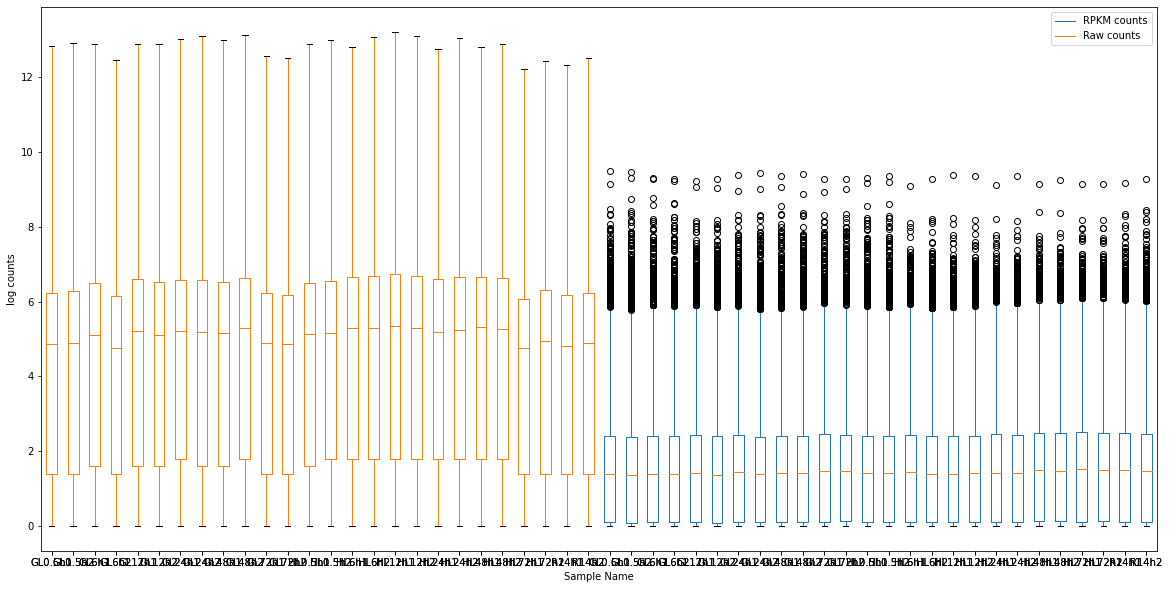

In [10]:
rpk = rpkm.RPKM()

In [11]:
rpk[0].to_excel(outdir+"/RPKM.xlsx", index=False)

In [ ]:

rpk[1].savefig("cpm.png",bbbox_anchor='tight', dpi=300)

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

In [ ]:
# a= np.log(rpk)

In [ ]:
r =rpk.corr()

In [ ]:
linked = shc.linkage(r, 'ward')


In [ ]:
R = shc.dendrogram(
                linked,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=len(r.columns),  # show only the last p merged clusters
                no_plot=True,
                )

In [ ]:
temp = {R["leaves"][ii]: r.columns[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

In [ ]:
shc.dendrogram(
            linked,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=len(r.columns),  # show only the last p merged clusters
            leaf_label_func=llf,
            orientation='left',
           
            leaf_font_size=8.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            )
ax = plt.gca()


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
for xlabel_i in ax.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for tick in ax.get_xticklines():
    tick.set_visible(False)

plt.savefig('deg.png', dpi=300, bbox_inches='tight')

In [ ]:
import pandas as pd
from pyseqrna import pyseqrna_plots as pp
from pyseqrna import gene_ontology as go

In [ ]:
rpk.to_excel(outdir+"/medianRatiocount.xlsx")

In [ ]:
result = pd.read_excel("pySeqRNA_results/Raw_DEGs_all.xlsx")

In [ ]:
outvolcano = os.path.join(outdir,"Volcano_Plots")
pu.make_directory(outvolcano)

In [ ]:
for c in comb:
        x,y =pp.plotVolcano(result,c,2)
        x.savefig(outvolcano+"/"+c+"_volcano.png", dpi=300)

In [ ]:
heatmap, ax = pp.plotHeatmap(result,comb,num=50, type='degs')

heatmap.savefig(os.path.join(outdir,"Top50_gene.png"), dpi=300)

In [ ]:
pu.getGenes(os.path.join(outdir,"filtered_DEGs.xlsx"),combinations=comb)

In [ ]:
outgo = os.path.join(outdir,"Gene_Ontology")
pu.make_directory(outgo)
gdata = go.query('athaliana')


In [ ]:
for c in comb:
    file = f"{outdir}/diff_genes/{c}.txt"
    ontology_results = go.enrichGO(gdata, file)
    ontology_results.to_csv(os.path.join(outgo, f"{c}_gene_ontology.txt"), sep="\t", index=False)

In [ ]:
import dill
dill.load_session("arabidopsis1.pyseqrna")

In [ ]:
from pyseqrna import pathway as pt
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats

In [ ]:
outkegg = os.path.join(outdir,"KEGG_pathway")



In [ ]:
df, background_count = pt.kegg_list('ath')

In [ ]:
for c in comb:
    file = f"{outdir}/diff_genes/{c}.txt"
    kegg_results = pt.enrichKEGG(file, df, background_count)
    kegg_results.to_csv(os.path.join(outkegg, f"{c}_kegg.txt"), sep="\t", index=False)

In [5]:

dill.load_session("arabidopsis.pyseqrna")

TypeError: __new__() missing 1 required positional argument: 'path'